# Limpieza de datos

## Carga de Datos

In [1]:
import pandas as pd

dataset_path = "../data/training.csv"
df_loaded = pd.read_csv(dataset_path)

## Procesamiento de datos

### Resumen del dataset

```pyhon
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11696 entries, 0 to 11695
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                11696 non-null  object 
 1   Store ID            11696 non-null  object 
 2   Product ID          11696 non-null  object 
 3   Category            11696 non-null  object 
 4   Region              11696 non-null  object 
 5   Inventory Level     11696 non-null  int64  
 6   Units Sold          11696 non-null  int64  
 7   Units Ordered       11696 non-null  int64  
 8   Demand Forecast     11696 non-null  float64
 9   Price               11696 non-null  float64
 10  Discount            11696 non-null  int64  
 11  Weather Condition   11696 non-null  object 
 12  Holiday/Promotion   11696 non-null  int64  
 13  Competitor Pricing  11696 non-null  float64
 14  Seasonality         11696 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 1.3+ MB
```

### Conclusion

Como el dataset no presenta datos nulos, se procedera a la transformacion de estos para su posterior limpieza de outliers.
En el dataset se presentan 7 columnas del tipo objetos, una parte de estos se eliminaran al no ser relevantes para la limpieza y el resto se dumificaran

#### Columnas categoricas relevantes

- Seasonality
- Weather Condition
- Region
- Category


### Columnas a eliminar

- Product ID
- Store ID
- Date

### Procesamiento de Datos

- Dumificar
- Escalado Robusto
- Descomponer
- Comprimir
- Limpiar Outliers
- Normalizar (entre -1 y 1)

In [2]:
from sklearn.preprocessing import OneHotEncoder

# En esta celda dumificaremos el dataset

# Creamos una copia del dataset cargado para luego mutarlo
df_dummified = df_loaded.copy()


# Dropeamos columnas irrelevantes
drop_list = ["Date", "Store ID", "Product ID"]
df_dummified = df_dummified.drop(columns=drop_list)


# Dumificamos el dataset transformando literales en columnas binarias
# Seleccionar columnas categóricas
categorical_columns = ["Category", "Region", "Weather Condition", "Seasonality"]

# Inicializar el codificador
encoder = OneHotEncoder(sparse_output=False)

# Aplicar transformación
encoded_array = encoder.fit_transform(df_dummified[categorical_columns])

# Convertir a DataFrame con los nombres de nuevas columnas
encoded_columns = encoder.get_feature_names_out(categorical_columns)
df_encoded = pd.DataFrame(encoded_array, columns=encoded_columns)

# Concatenar con el DataFrame original, eliminando las columnas originales
df_dummified = df_dummified.drop(columns=categorical_columns).reset_index(drop=True)
df_dummified = pd.concat([df_dummified, df_encoded], axis=1)

# Verificamos dataset dumificado
df_dummified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11696 entries, 0 to 11695
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Inventory Level           11696 non-null  int64  
 1   Units Sold                11696 non-null  int64  
 2   Units Ordered             11696 non-null  int64  
 3   Demand Forecast           11696 non-null  float64
 4   Price                     11696 non-null  float64
 5   Discount                  11696 non-null  int64  
 6   Holiday/Promotion         11696 non-null  int64  
 7   Competitor Pricing        11696 non-null  float64
 8   Category_Clothing         11696 non-null  float64
 9   Category_Electronics      11696 non-null  float64
 10  Category_Furniture        11696 non-null  float64
 11  Category_Groceries        11696 non-null  float64
 12  Category_Toys             11696 non-null  float64
 13  Region_East               11696 non-null  float64
 14  Region

In [3]:
from sklearn.preprocessing import RobustScaler

# En esta celda normalizamos el dataset dumificado
# creamos una copia para luego mutarla y conservar el original antes trabajado
df_scaled = df_dummified.copy()

# Creamos el escalador
scaler = RobustScaler()
data_scaled = scaler.fit_transform(df_scaled)

# Convertimos a Dataframe el dataset escalado
df_scaled = pd.DataFrame(data_scaled, columns=df_scaled.columns)

# Visualizamos el minimo y maximo de las columnas escaladas
df_scaled.describe().loc[["min", "max"]]

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Category_Clothing,Category_Electronics,...,Region_South,Region_West,Weather Condition_Cloudy,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Autumn,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
min,-1.008811,-0.696774,-1.011236,-0.798668,-1.001221,-1.0,0.0,-1.104522,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.973568,2.490323,1.011236,2.553874,0.996559,1.0,1.0,1.109418,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [4]:
import numpy as np
from sklearn.decomposition import PCA

# En esta celda Descompondremos en componentes principales el dataset normalizado
pca = PCA()
pca.fit(df_scaled)

# Obtener la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
mean_variance = explained_variance.mean() # Media de la varianza explicada

# Ponderamos la varianza media para incluir mas componentes principales
# y aumentar la varianza total explicada
weighted_mean_variance = mean_variance * 0.82

# Seleccionamos los Indices de componentes relevantes
selected_components = np.where(explained_variance > weighted_mean_variance)[0]

# Aplicar PCA con solo las componentes seleccionadas
pca_selected = PCA(n_components=len(selected_components))
compressed_data = pca_selected.fit_transform(df_scaled)

# Convertir a DataFrame
df_compressed = pd.DataFrame(compressed_data)

# Calculamos la varianza total explicada de las componentes seleccionadas
total_explained_variance = np.sum(explained_variance[selected_components]) * 100


print(f"Varianza Total Explicada: {total_explained_variance:.2f}%")
df_compressed.info()
df_compressed.describe().loc[["min", "max"]]

Varianza Total Explicada: 87.30%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11696 entries, 0 to 11695
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       11696 non-null  float64
 1   1       11696 non-null  float64
 2   2       11696 non-null  float64
 3   3       11696 non-null  float64
 4   4       11696 non-null  float64
 5   5       11696 non-null  float64
 6   6       11696 non-null  float64
 7   7       11696 non-null  float64
 8   8       11696 non-null  float64
 9   9       11696 non-null  float64
 10  10      11696 non-null  float64
 11  11      11696 non-null  float64
 12  12      11696 non-null  float64
 13  13      11696 non-null  float64
 14  14      11696 non-null  float64
dtypes: float64(15)
memory usage: 1.3 MB


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
min,-1.614499,-1.549255,-1.102250,-1.097807,-1.042205,-1.138483,-1.145875,-1.021925,-1.094200,-1.270129,-0.873670,-1.295408,-1.042831,-1.130071,-0.506791
max,3.467584,1.544817,1.075005,1.081896,1.394923,1.480363,1.311102,1.302927,1.378623,1.323888,1.265482,1.213946,1.306214,1.465972,1.098097


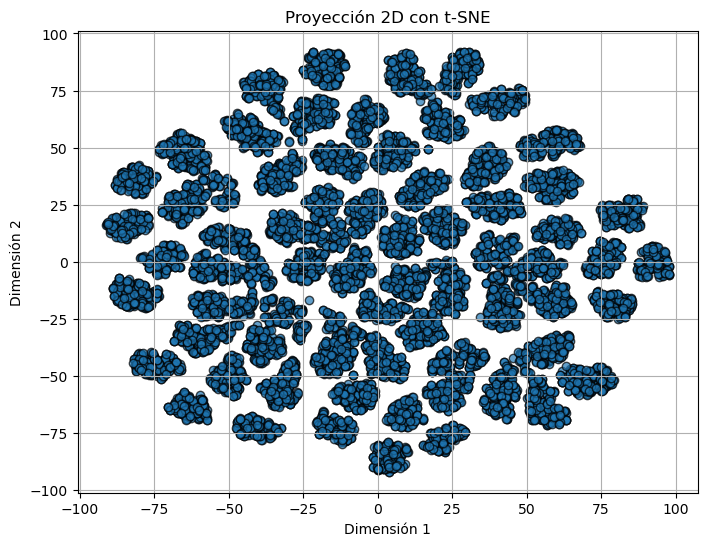

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# AVISO: Esta celda tiene un alto coste computacional para renderizar el grafico
# Aplicar t-SNE para reducir a 2 dimensiones
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
df_2d = tsne.fit_transform(df_compressed)

# Graficar los puntos en 2D
plt.figure(figsize=(8, 6))
plt.scatter(df_2d[:, 0], df_2d[:, 1], alpha=0.7, edgecolors="k")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.title("Proyección 2D con t-SNE")
plt.grid(visible=True)
plt.show()


In [13]:
# TODO @Seba1996c: Limpiar Outliers y guardar indices de las filas eliminadas
# NOTE Rango intercuartílico (IQR), Isolation Forest o DBSCAN


✅ Limpieza completa: 2646 filas eliminadas.


In [14]:
import pandas as pd
import os

# Define la carpeta de destino a donde debe llegar
output_dir = os.path.join('..', 'data')

# Crea la carpeta (y subcarpetas) si no existen
os.makedirs(output_dir, exist_ok=True)

# --- Función para limpiar outliers y guardar índices ---
def limpiar_outliers_iqr(df, columnas):
    indices_eliminados = set()
    df_limpio = df.copy()

    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        outliers = df_limpio[(df_limpio[col] < limite_inferior) | (df_limpio[col] > limite_superior)].index
        indices_eliminados.update(outliers)

    indices_eliminados = sorted(list(indices_eliminados))
    df_limpio = df_limpio.drop(index=indices_eliminados)

    return df_limpio, indices_eliminados

# --- Aplicar a df_compressed ---
columnas_numericas = df_compressed.select_dtypes(include=['float64', 'int64']).columns
df_compressed_limpio, indices_outliers = limpiar_outliers_iqr(df_compressed, columnas_numericas)

# --- Guardar archivos en ../data ---
df_compressed_limpio.to_csv(os.path.join(output_dir, 'lstm_training.csv'), index=False)
pd.Series(indices_outliers, name='indices_outliers').to_csv(os.path.join(output_dir, 'outliers_indices.csv'), index=False)

# --- Confirmación ---
print(f"✅ Archivo limpio guardado en: {os.path.join(output_dir, 'lstm_training.csv')}")
print(f"📌 Índices de outliers guardados en: {os.path.join(output_dir, 'outliers_indices.csv')}")
print(f"🧹 Total de filas eliminadas: {len(indices_outliers)}")


✅ Archivo limpio guardado en: ../data/lstm_training.csv
📌 Índices de outliers guardados en: ../data/outliers_indices.csv
🧹 Total de filas eliminadas: 2646


In [15]:
df_compressed_limpio

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2.815464,0.864913,-1.058608,0.766393,-0.395132,-0.043744,0.265567,0.837090,0.286760,0.361843,0.335203,0.514680,-0.946079,-0.052530,-0.393148
1,0.862551,-0.240883,0.526846,-0.878528,0.697018,-0.023757,0.068196,0.667151,-0.285877,-1.100353,-0.022667,-0.025964,-0.455991,0.094634,-0.300122
2,-0.623048,-0.935660,-0.496271,0.761034,-0.247491,-0.754621,-0.171111,0.567904,0.355263,-0.907307,-0.475056,-0.263095,-0.576301,0.351631,-0.502369
3,-1.350877,1.073213,0.029885,-0.889159,-0.287593,0.081074,0.315834,0.909388,0.182455,0.302423,0.289788,0.538839,-0.887380,-0.139983,-0.307476
4,1.046920,1.273692,0.967616,0.791874,0.350612,-0.586747,-0.196158,0.206911,-0.200518,0.285180,0.081299,0.719803,-0.195954,1.227886,-0.357264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11691,-1.064261,-1.120709,-0.999214,0.152530,0.263661,0.252269,0.376513,0.288420,0.459112,0.443122,-0.789593,0.916231,0.380015,-0.069833,-0.282051
11692,0.579213,0.844859,-1.017042,0.923703,0.652482,1.037225,-0.501415,0.108877,0.187855,-0.122900,0.095114,-0.582846,-0.067213,0.072463,-0.035742
11693,-0.092277,0.921075,0.495203,-0.849343,0.665445,-0.411394,-0.449128,-0.190797,-0.155492,1.255575,0.304420,-0.057949,-0.163416,0.196205,-0.238583
11694,-1.400211,-1.400768,0.030626,-0.958213,0.559302,-0.338993,-0.972350,-0.244653,0.773675,0.357193,-0.583254,-0.046223,-0.048284,0.094622,-0.166730


In [7]:
# TODO @Seba1996c: Normalizar entre -1 y 1

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Crear el escalador con rango [-1, 1]
escalador = MinMaxScaler(feature_range=(-1, 1))

# Aplicar solo a columnas numéricas
columnas_numericas = df_compressed_limpio.select_dtypes(include=['float64', 'int64']).columns

# Normalizar
df_compressed_normalizado = df_compressed_limpio.copy()
df_compressed_normalizado[columnas_numericas] = escalador.fit_transform(df_compressed_limpio[columnas_numericas])


In [17]:
df_compressed_normalizado

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.934511,0.560511,-0.959883,0.718122,-0.465035,-0.175496,0.148926,0.599255,0.161843,0.258258,0.130235,0.457772,-0.916801,-0.122458,-0.597202
1,0.081697,-0.154272,0.497508,-0.797904,0.437895,-0.159756,-0.011736,0.453061,-0.319934,-0.869102,-0.204355,0.022359,-0.490139,-0.002609,-0.267479
2,-0.567045,-0.603374,-0.442968,0.713183,-0.342973,-0.735361,-0.206534,0.367682,0.219476,-0.720262,-0.627316,-0.168617,-0.594878,0.206688,-0.984325
3,-0.884880,0.695156,0.040688,-0.807702,-0.376128,-0.077194,0.189844,0.661450,0.074088,0.212445,0.087775,0.477228,-0.865698,-0.193679,-0.293546
4,0.162209,0.824745,0.902675,0.741607,0.151506,-0.603148,-0.226922,0.057131,-0.248119,0.199151,-0.107152,0.622970,-0.263754,0.920304,-0.470014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11691,-0.759718,-0.722989,-0.905286,0.152361,0.079619,0.057634,0.239237,0.127250,0.306848,0.320925,-0.921392,0.781165,0.237675,-0.136549,-0.203430
11692,-0.042033,0.547549,-0.921674,0.863105,0.401076,0.675840,-0.475404,-0.027205,0.078631,-0.115481,-0.094235,-0.426132,-0.151675,-0.020664,0.669592
11693,-0.335264,0.596815,0.468421,-0.771006,0.411792,-0.465046,-0.432842,-0.285006,-0.210237,0.947330,0.101455,-0.003400,-0.235427,0.080110,-0.049359
11694,-0.906423,-0.904018,0.041369,-0.871345,0.324039,-0.408025,-0.858749,-0.331336,0.571499,0.254673,-0.728475,0.006043,-0.135195,-0.002618,0.205319


In [8]:
# TODO @Seba1996c: Cambiar los indices del Data Frame final por la columna Date

# NOTE: Filtar los indices eliminados antes de agregar las columnas

In [20]:
# Paso 1: Recuperar columna 'Date' sin los índices de los outliers
date_sin_outliers = df_loaded['Date'].drop(index=indices_outliers).reset_index(drop=True)

# Paso 2: Agregar la columna 'Date' al DataFrame normalizado
df_compressed_normalizado = df_compressed_normalizado.copy()
df_compressed_normalizado['Date'] = date_sin_outliers

# Paso 3: Establecer 'Date' como índice
df_compressed_normalizado.set_index('Date', inplace=True)

print("✅ 'Date' ha sido establecida como índice en df_compressed_normalizado.")




✅ 'Date' ha sido establecida como índice en df_compressed_normalizado.


In [21]:
df_compressed_normalizado

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Date,,,,,,,,,,,,,,,
2022-11-19,0.934511,0.560511,-0.959883,0.718122,-0.465035,-0.175496,0.148926,0.599255,0.161843,0.258258,0.130235,0.457772,-0.916801,-0.122458,-0.597202
2023-06-29,0.081697,-0.154272,0.497508,-0.797904,0.437895,-0.159756,-0.011736,0.453061,-0.319934,-0.869102,-0.204355,0.022359,-0.490139,-0.002609,-0.267479
2022-03-10,-0.567045,-0.603374,-0.442968,0.713183,-0.342973,-0.735361,-0.206534,0.367682,0.219476,-0.720262,-0.627316,-0.168617,-0.594878,0.206688,-0.984325
2022-02-07,-0.884880,0.695156,0.040688,-0.807702,-0.376128,-0.077194,0.189844,0.661450,0.074088,0.212445,0.087775,0.477228,-0.865698,-0.193679,-0.293546
2022-06-23,0.162209,0.824745,0.902675,0.741607,0.151506,-0.603148,-0.226922,0.057131,-0.248119,0.199151,-0.107152,0.622970,-0.263754,0.920304,-0.470014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,-0.759718,-0.722989,-0.905286,0.152361,0.079619,0.057634,0.239237,0.127250,0.306848,0.320925,-0.921392,0.781165,0.237675,-0.136549,-0.203430
NaN,-0.042033,0.547549,-0.921674,0.863105,0.401076,0.675840,-0.475404,-0.027205,0.078631,-0.115481,-0.094235,-0.426132,-0.151675,-0.020664,0.669592
NaN,-0.335264,0.596815,0.468421,-0.771006,0.411792,-0.465046,-0.432842,-0.285006,-0.210237,0.947330,0.101455,-0.003400,-0.235427,0.080110,-0.049359


In [9]:
# TODO @Seba1996c: Guardar DataFrame final como archivo .csv

In [22]:
# Guardar el DataFrame final como CSV en ../data
nombre_archivo = 'lstm_training_normalizado.csv'
ruta_salida = os.path.join(output_dir, nombre_archivo)

df_compressed_normalizado.to_csv(ruta_salida)

print(f"✅ DataFrame final guardado como CSV en: {ruta_salida}")


✅ DataFrame final guardado como CSV en: ../data/lstm_training_normalizado.csv


In [10]:
# TODO @Seba1996c: Guardar todos los encoders generados y crear una pipeline

In [23]:
import joblib
import os

# Crear carpeta de modelos si no existe
modelos_dir = os.path.join('..', 'models')
os.makedirs(modelos_dir, exist_ok=True)

# Guardar el MinMaxScaler
scaler_path = os.path.join(modelos_dir, 'minmax_scaler.pkl')
joblib.dump(escalador, scaler_path)

print(f"✅ MinMaxScaler guardado en: {scaler_path}")


✅ MinMaxScaler guardado en: ../models/minmax_scaler.pkl


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression  # o cualquier otro

pipeline = Pipeline([
    ('scaler', escalador),
    ('modelo', LogisticRegression())  # este puedes cambiarlo por tu modelo final
])


In [ ]:
### Incumplimiendo de objetivos
# Limpieza de Outliers mal configurada, se elimino mas del 22% del dataset.
# Los outliers no representan más del 5% de un dataset.
# El metodo IQR requiere una configuracion manual del umbral para cada columna
# Si se dedice usar este metodo es importante analizar primero donde se
# Encuentran los outliers usando un grafico de caja.

# La columna Date no se integro correctamente, se introducieron datos nulos.

# Solo se debia guardar el dataset normalizado y la pipeline, sin embargo,
# está última no considera todos los encoders generados durante
# el procesamiento de datos.


### Codigo a mejorar
# Evitar cambiar el kernel virtual del proyecto por uno local u otro kernel de python.

# Evitar usar iteradores o estructuras de datos nativas de python
# como bucles for, listas o sets, en su lugar, usar numpy y pandas.

# Comprobaciones de tipo innecesarias.

# Generacion de archivos innecesarios.

# Generacion de reportes ineficientes en lugar de mostrar los cambios realizados
# (imprimir el dataset completo se considera mala practica).

# Seguir reglas de estilo al codificar, codigo en ingles, double quotes
# y solo comentarios en español, seguir las reglas del linter del proyecto.